In [1]:
# MLflow model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualizations
import matplotlib.pyplot as plt

# math functions
import numpy as np

# read CSV file
import os
import glob

# data frames
import pandas as pd

# regexes
import re

# Print pandas.describe() in PDF
from prettytable import PrettyTable

# Disable automated output
import warnings
# Future deprecation warnings
warnings.filterwarnings("ignore")

In [2]:
# https://medium.com/bitgrit-data-science-publication/sentiment-analysis-on-reddit-tech-news-with-python-cbaddb8e9bb6

# Load NLTK Libraries

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# Downloading NLTK's databases
nltk.download('vader_lexicon', quiet=True); # get lexicons data
nltk.download('punkt', quiet=True); # for tokenizer
nltk.download('stopwords', quiet=True); # dictionary for tokenization

In [3]:
# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

In [4]:
# Use the Reddit dataset
topics_dict = { "date":[],
                "title":[],
                "author":[],
                "stickied":[],
                "upvote_ratio":[],
                "score":[],
                "id":[],
                "url":[],
                "num_comments": [],
                "created": [],
                "body":[]}

df = pd.DataFrame()
running_total = 0
for fname in glob.glob(os.path.abspath('./*.meta')):
    metadata = pd.read_csv(fname)

for fname in glob.glob(os.path.abspath('./**/*.csv')):
    _df=pd.read_csv(fname)
    _df['query'] = os.path.splitext(os.path.basename(fname))[0]
    subreddit = os.path.basename(os.path.dirname(fname))
    _df['subreddit'] = subreddit
    _df['score_weighted'] = _df['score'] / metadata[metadata['name']==subreddit]['subscribers'].iloc[0]
    _df['num_comments_weighted'] = _df['num_comments'] / metadata[metadata['name']==subreddit]['subscribers'].iloc[0]
    # df = df.append(_df.copy(), ignore_index=True)
    df = pd.concat([df, _df], ignore_index=True)
    running_total+=len(_df)
    # print(fname)
    #print(running_total)
    #break #DEBUG

# remove duplicate posts
df.set_index("id", inplace=True)
print(f"Total imported data: {running_total}")
print(f"Duplicate Reddit posts: {running_total-len(df)}")

# setup the created datetime
df['created_date'] = pd.to_datetime(df['created'], unit='s')
df['dtdate'] = df['created_date'].dt.date

Total imported data: 10603
Duplicate Reddit posts: 0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62622 entries, 16s0f0i to 9533g8
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             62622 non-null  int64         
 1   date                   62622 non-null  object        
 2   title                  62622 non-null  object        
 3   author                 62622 non-null  object        
 4   stickied               62622 non-null  bool          
 5   upvote_ratio           62622 non-null  float64       
 6   score                  62622 non-null  int64         
 7   url                    62622 non-null  object        
 8   num_comments           62622 non-null  int64         
 9   created                62622 non-null  float64       
 10  body                   36443 non-null  object        
 11  query                  62622 non-null  object        
 12  subreddit              62622 non-null  object        
 13 

There are still missing values in 'body column'. Instead of ommit them, we will replace it by titles

In [5]:
# we will only use the following columns to help us remove duplicate values
clean_a = df[['date', 'title', 'author', 'stickied', 'upvote_ratio', 'score', 'url', 'num_comments', 'created', 'body', 'score_weighted', 'num_comments_weighted', 'created_date', 'dtdate']]

In [6]:
# if body is empty, use titleclean_a['body'].fillna(df['title'], inplace=True)
clean_a['body'].fillna(clean_a['title'], inplace=True)

In [7]:
clean_a.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10603 entries, 16s0f0i to 17pq87e
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   10603 non-null  object        
 1   title                  10603 non-null  object        
 2   author                 10601 non-null  object        
 3   stickied               10603 non-null  bool          
 4   upvote_ratio           10603 non-null  float64       
 5   score                  10603 non-null  int64         
 6   url                    10603 non-null  object        
 7   num_comments           10603 non-null  int64         
 8   created                10603 non-null  float64       
 9   body                   10603 non-null  object        
 10  score_weighted         10603 non-null  float64       
 11  num_comments_weighted  10603 non-null  float64       
 12  created_date           10603 non-null  datetime64[ns]
 13

In [8]:
# auxilary function to clean the text

#Create a function to clean the tweets
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0–9]+', '', text) #Remove @mentions replace with blank
    text = re.sub(r'#', '', text) #Remove the ‘#’ symbol, replace with blank
    text = re.sub(r'RT[\s]+', '', text) #Removing RT, replace with blank
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlinks
    text = re.sub(r':', '', text) # Remove :
    return text

#Next we have to remove emoji & Unicode from the Tweet data.
def remove_emoji(string):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002500-\U00002BEF" # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f" # dingbats
    u"\u3030"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [9]:
# clean the text
clean_a['body'] = clean_a['body'].apply(cleanTxt).apply(remove_emoji)

In [10]:
clean_a.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10603 entries, 16s0f0i to 17pq87e
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   10603 non-null  object        
 1   title                  10603 non-null  object        
 2   author                 10601 non-null  object        
 3   stickied               10603 non-null  bool          
 4   upvote_ratio           10603 non-null  float64       
 5   score                  10603 non-null  int64         
 6   url                    10603 non-null  object        
 7   num_comments           10603 non-null  int64         
 8   created                10603 non-null  float64       
 9   body                   10603 non-null  object        
 10  score_weighted         10603 non-null  float64       
 11  num_comments_weighted  10603 non-null  float64       
 12  created_date           10603 non-null  datetime64[ns]
 13

In [11]:
# check for duplicates before removing them
duplicate = clean_a[clean_a.duplicated(subset=['body'])].sort_values(by='body')

duplicate['body']

id
10gtruu                                                     
1323w68                                                     
10gtruu                                                     
10gtruu                                                     
p1zkqp                                                      
                                 ...                        
13l4j5r          ‎OpenAI released a ChatGPT app on App Store
13l4j5r          ‎OpenAI released a ChatGPT app on App Store
12cczbg    “Building a kind of JARVIS @ OpenAI” - Karpath...
13ekrio    “Google are ahead of OpenAI after today” “Bard...
13o955c    “What is my purpose? To pass the butter?”\n\nT...
Name: body, Length: 6370, dtype: object

In [12]:
print(f"Imported Data: {len(df)}"), print(f"Duplicate posts: {len(duplicate['body'])}")

Imported Data: 10603
Duplicate posts: 6370


(None, None)

In [13]:
# remove duplicate posts
clean_b = clean_a[['date', 'title', 'author', 'stickied', 'upvote_ratio', 'score', 'url', 'num_comments', 'created', 'body', 'score_weighted', 'num_comments_weighted', 'created_date', 'dtdate']]
clean_b.drop_duplicates(subset='body', keep='first', inplace=True)

In [14]:
# check for duplicates after removing them, clean_b is the clean dataframe
duplicate = clean_b[clean_b.duplicated(subset=['body'])].sort_values(by='body')
duplicate['body']

Series([], Name: body, dtype: object)

In [15]:
clean_b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4233 entries, 16s0f0i to 17pq87e
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   4233 non-null   object        
 1   title                  4233 non-null   object        
 2   author                 4231 non-null   object        
 3   stickied               4233 non-null   bool          
 4   upvote_ratio           4233 non-null   float64       
 5   score                  4233 non-null   int64         
 6   url                    4233 non-null   object        
 7   num_comments           4233 non-null   int64         
 8   created                4233 non-null   float64       
 9   body                   4233 non-null   object        
 10  score_weighted         4233 non-null   float64       
 11  num_comments_weighted  4233 non-null   float64       
 12  created_date           4233 non-null   datetime64[ns]
 13 

In [16]:
df[df['title'].str.contains('ChatGPT holds ‘systemic’ left-wing bias researchers say', case=False)]

,Unnamed: 0,subreddit,query,sort,date,title,author,stickied,upvote_ratio,score,url,num_comments,created,body,score_weighted,num_comments_weighted,created_date,dtdate
id,,,,,,,,,,,,,,,,,,
15th76l,100,chatgpt,chatgpt,comments,2023-08-17 08:24:14,ChatGPT holds ‘systemic’ left-wing bias resear...,True-Lychee,False,0.73,12104,https://i.redd.it/a7vuti6prmib1.png,9029,1.692261e+09,NaN,0.002722,0.002031,2023-08-17 08:24:14,2023-08-17
15th76l,213,chatgpt,chatgpt,relevance,2023-08-17 08:24:14,ChatGPT holds ‘systemic’ left-wing bias resear...,True-Lychee,False,0.73,12111,https://i.redd.it/a7vuti6prmib1.png,9029,1.692261e+09,NaN,0.002724,0.002031,2023-08-17 08:24:14,2023-08-17
15th76l,50,chatgpt,gpt,top,2023-08-17 08:24:14,ChatGPT holds ‘systemic’ left-wing bias resear...,True-Lychee,False,0.73,12106,https://i.redd.it/a7vuti6prmib1.png,9029,1.692261e+09,NaN,0.002723,0.002031,2023-08-17 08:24:14,2023-08-17
15th76l,100,chatgpt,gpt,comments,2023-08-17 08:24:14,ChatGPT holds ‘systemic’ left-wing bias resear...,True-Lychee,False,0.73,12097,https://i.redd.it/a7vuti6prmib1.png,9029,1.692261e+09,NaN,0.002721,0.002031,2023-08-17 08:24:14,2023-08-17
15th76l,221,chatgpt,gpt,relevance,2023-08-17 08:24:14,ChatGPT holds ‘systemic’ left-wing bias resear...,True-Lychee,False,0.73,12101,https://i.redd.it/a7vuti6prmib1.png,9029,1.692261e+09,NaN,0.002721,0.002031,2023-08-17 08:24:14,2023-08-17


In [17]:
clean_b.groupby(['author', 'date']).size().reset_index(name='count').sort_values(by='count', ascending=False)

,author,date,count
0,--leockl--,2023-09-22 10:08:15,1
2826,goldfeld,2023-03-08 23:05:47,1
2812,ghostderp,2018-11-13 00:56:32,1
2813,gi_beelzebub,2023-06-20 20:31:53,1
2814,gihangamage,2023-07-16 12:25:22,1
...,...,...,...
1416,Opening-Ad-8849,2023-02-13 14:27:01,1
1417,Opening-Ad-8849,2023-02-13 16:08:34,1
1418,Opening-Ad-8849,2023-03-07 17:07:23,1
1419,OpeningMarsupial7229,2023-01-12 07:08:04,1


In [18]:
clean_b.groupby(['author', 'title'])['num_comments'].sum().sort_values(ascending=False)

author           title                                                                                                                                                                               
True-Lychee      ChatGPT holds ‘systemic’ left-wing bias researchers say                                                                                                                                 9029
hi_there_bitch   r/ChatGPT Lounge                                                                                                                                                                        5464
Whyamiani        Lost all my content writing contracts. Feeling hopeless as an author.                                                                                                                   3835
EthanGaming7640  What do you get when you put your username into DALL-E?                                                                                                                

In [19]:
# get body clean_b
body_dt = clean_b['body']

In [20]:
def generate_wordcloud(text, stopwords = None, mask = None):
    """Generate Word Cloud"""

    from PIL import Image
    import numpy as np
    from wordcloud import WordCloud
    
    mask_object = None
    if mask != None:
        mask_object = np.array(Image.open(mask))
        
    wordcloud = WordCloud(width = 1200, height = 600, stopwords = stopwords, max_font_size = 200, mask = mask_object, background_color = 'white', colormap = 'viridis')
    wordcloud = wordcloud.generate(' '.join(text))
    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

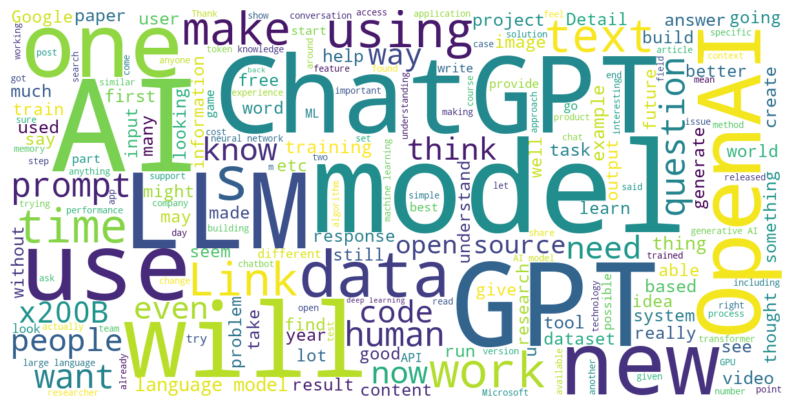

In [21]:
# create wordcloud from body
generate_wordcloud(body_dt)

In [22]:
#Downloading NLTK’s databases
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
from pprint import pprint
sid = SentimentIntensityAnalyzer()

res = [*clean_a['title'].apply(sid.polarity_scores)]
pprint(res[:3])

[{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': -0.3818, 'neg': 0.302, 'neu': 0.698, 'pos': 0.0},
 {'compound': 0.5984, 'neg': 0.0, 'neu': 0.606, 'pos': 0.394}]


In [24]:
clean_a = clean_a.reset_index(drop=True)

sentiment_df = pd.DataFrame.from_records(res)
gpta = pd.concat([clean_a, sentiment_df], axis=1, join='inner')
gpta.head()

,date,title,author,stickied,upvote_ratio,score,url,num_comments,created,body,score_weighted,num_comments_weighted,created_date,dtdate,neg,neu,pos,compound
0,2023-09-25 18:50:02,"ChatGPT Can Now See, Hear, and Speak.",Senior_tasteey,False,1.00,2409,https://www.godofprompt.ai/blog/chatgpt-can-no...,22,1.695668e+09,"ChatGPT Can Now See, Hear, and Speak.",0.003376,0.000031,2023-09-25 18:50:02,2023-09-25,0.000,1.000,0.000,0.0000
1,2023-04-04 18:29:49,Rap battle between ChatGPT and Google Bard,seasick__crocodile,False,0.97,769,https://www.reddit.com/gallery/12brxc1,158,1.680633e+09,"Aside from each program’s first turn, both wer...",0.001078,0.000221,2023-04-04 18:29:49,2023-04-04,0.302,0.698,0.000,-0.3818
2,2023-12-23 12:31:57,The most remarkable AI releases of 2023,alina_valyaeva,False,0.93,678,https://i.redd.it/1ues5xc8g18c1.png,95,1.703335e+09,The most remarkable AI releases of 2023,0.000950,0.000133,2023-12-23 12:31:57,2023-12-23,0.000,0.606,0.394,0.5984
3,2022-12-29 18:33:34,ChatGPT's Gender Sensitivity: Is It Joking Abo...,bratwurstgeraet,False,0.89,518,https://i.redd.it/zag7mgdw9x8a1.jpg,72,1.672339e+09,"Hey Redditors,\n\nI just had a really interest...",0.000726,0.000101,2022-12-29 18:33:34,2022-12-29,0.000,0.900,0.100,0.1154
4,2023-04-01 11:43:57,ChatGPT creates a game to play and then loses ...,benaugustine,False,0.97,493,https://i.imgur.com/cK7C7LM.jpg,88,1.680349e+09,ChatGPT creates a game to play and then loses ...,0.000691,0.000123,2023-04-01 11:43:57,2023-04-01,0.137,0.595,0.268,0.2960


In [25]:
THRESHOLD = 0.2

conditions = [
    (gpta['compound'] <= -THRESHOLD),
    (gpta['compound'] > -THRESHOLD) & (gpta['compound'] < THRESHOLD),
    (gpta['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
gpta['label'] = np.select(conditions, values)

gpta.head()

,date,title,author,stickied,upvote_ratio,score,url,num_comments,created,body,score_weighted,num_comments_weighted,created_date,dtdate,neg,neu,pos,compound,label
0,2023-09-25 18:50:02,"ChatGPT Can Now See, Hear, and Speak.",Senior_tasteey,False,1.00,2409,https://www.godofprompt.ai/blog/chatgpt-can-no...,22,1.695668e+09,"ChatGPT Can Now See, Hear, and Speak.",0.003376,0.000031,2023-09-25 18:50:02,2023-09-25,0.000,1.000,0.000,0.0000,neu
1,2023-04-04 18:29:49,Rap battle between ChatGPT and Google Bard,seasick__crocodile,False,0.97,769,https://www.reddit.com/gallery/12brxc1,158,1.680633e+09,"Aside from each program’s first turn, both wer...",0.001078,0.000221,2023-04-04 18:29:49,2023-04-04,0.302,0.698,0.000,-0.3818,neg
2,2023-12-23 12:31:57,The most remarkable AI releases of 2023,alina_valyaeva,False,0.93,678,https://i.redd.it/1ues5xc8g18c1.png,95,1.703335e+09,The most remarkable AI releases of 2023,0.000950,0.000133,2023-12-23 12:31:57,2023-12-23,0.000,0.606,0.394,0.5984,pos
3,2022-12-29 18:33:34,ChatGPT's Gender Sensitivity: Is It Joking Abo...,bratwurstgeraet,False,0.89,518,https://i.redd.it/zag7mgdw9x8a1.jpg,72,1.672339e+09,"Hey Redditors,\n\nI just had a really interest...",0.000726,0.000101,2022-12-29 18:33:34,2022-12-29,0.000,0.900,0.100,0.1154,neu
4,2023-04-01 11:43:57,ChatGPT creates a game to play and then loses ...,benaugustine,False,0.97,493,https://i.imgur.com/cK7C7LM.jpg,88,1.680349e+09,ChatGPT creates a game to play and then loses ...,0.000691,0.000123,2023-04-01 11:43:57,2023-04-01,0.137,0.595,0.268,0.2960,pos


In [26]:
gpta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10603 entries, 0 to 10602
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   10603 non-null  object        
 1   title                  10603 non-null  object        
 2   author                 10601 non-null  object        
 3   stickied               10603 non-null  bool          
 4   upvote_ratio           10603 non-null  float64       
 5   score                  10603 non-null  int64         
 6   url                    10603 non-null  object        
 7   num_comments           10603 non-null  int64         
 8   created                10603 non-null  float64       
 9   body                   10603 non-null  object        
 10  score_weighted         10603 non-null  float64       
 11  num_comments_weighted  10603 non-null  float64       
 12  created_date           10603 non-null  datetime64[ns]
 13  d

In [27]:
clean_c = gpta[['date', 'title', 'author', 'stickied', 'upvote_ratio', 'score', 'url', 'num_comments', 'created', 'body', 'score_weighted', 'num_comments_weighted', 'created_date', 'dtdate', 'neg', 'neu', 'pos', 'compound', 'label']]
clean_c.drop_duplicates(subset='body', keep='first', inplace=True)

clean_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4233 entries, 0 to 10602
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   4233 non-null   object        
 1   title                  4233 non-null   object        
 2   author                 4231 non-null   object        
 3   stickied               4233 non-null   bool          
 4   upvote_ratio           4233 non-null   float64       
 5   score                  4233 non-null   int64         
 6   url                    4233 non-null   object        
 7   num_comments           4233 non-null   int64         
 8   created                4233 non-null   float64       
 9   body                   4233 non-null   object        
 10  score_weighted         4233 non-null   float64       
 11  num_comments_weighted  4233 non-null   float64       
 12  created_date           4233 non-null   datetime64[ns]
 13  dtdate 

In [28]:
from datetime import datetime

start_date_str = '2022-11-01'
end_date_str = '2023-01-31'

start_date = datetime.strptime(start_date_str, '%Y-%m-%d').date()
end_date = datetime.strptime(end_date_str, '%Y-%m-%d').date()

gpt_old = clean_c.copy()

gpt_old = gpt_old[(gpt_old['dtdate'] >= start_date) & (gpt_old['dtdate'] <= end_date)]

gpt_old.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275 entries, 3 to 10195
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   275 non-null    object        
 1   title                  275 non-null    object        
 2   author                 275 non-null    object        
 3   stickied               275 non-null    bool          
 4   upvote_ratio           275 non-null    float64       
 5   score                  275 non-null    int64         
 6   url                    275 non-null    object        
 7   num_comments           275 non-null    int64         
 8   created                275 non-null    float64       
 9   body                   275 non-null    object        
 10  score_weighted         275 non-null    float64       
 11  num_comments_weighted  275 non-null    float64       
 12  created_date           275 non-null    datetime64[ns]
 13  dtdate  

In [29]:
gpt_old.label.value_counts(), gpt_old.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275 entries, 3 to 10195
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   275 non-null    object        
 1   title                  275 non-null    object        
 2   author                 275 non-null    object        
 3   stickied               275 non-null    bool          
 4   upvote_ratio           275 non-null    float64       
 5   score                  275 non-null    int64         
 6   url                    275 non-null    object        
 7   num_comments           275 non-null    int64         
 8   created                275 non-null    float64       
 9   body                   275 non-null    object        
 10  score_weighted         275 non-null    float64       
 11  num_comments_weighted  275 non-null    float64       
 12  created_date           275 non-null    datetime64[ns]
 13  dtdate  

(label
 neu    173
 pos     73
 neg     29
 Name: count, dtype: int64,
 None)

In [62]:
# plot sentiment ditribution without duplicate value and date range below 31 nov 2022
# sns.histplot(gpt_old.label), plt.pie(gpt_old[''], labels=label, autopct='%1.1f%%', startangle=90)

In [30]:
df_p = gpt_old['dtdate'].value_counts().rename_axis('dtdate').reset_index(name='counts').sort_values(by='dtdate')

df_c = gpt_old.groupby('dtdate')['num_comments'].sum().reset_index().sort_values(by='dtdate')

In [31]:
df_px = clean_c['dtdate'].value_counts().rename_axis('dtdate').reset_index(name='counts').sort_values(by='dtdate')

df_cx = clean_c.groupby('dtdate')['num_comments'].sum().reset_index().sort_values(by='dtdate')

In [32]:
gpt_old.info(), clean_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275 entries, 3 to 10195
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   275 non-null    object        
 1   title                  275 non-null    object        
 2   author                 275 non-null    object        
 3   stickied               275 non-null    bool          
 4   upvote_ratio           275 non-null    float64       
 5   score                  275 non-null    int64         
 6   url                    275 non-null    object        
 7   num_comments           275 non-null    int64         
 8   created                275 non-null    float64       
 9   body                   275 non-null    object        
 10  score_weighted         275 non-null    float64       
 11  num_comments_weighted  275 non-null    float64       
 12  created_date           275 non-null    datetime64[ns]
 13  dtdate  

(None, None)

<Axes: title={'center': 'Number of Comments'}, xlabel='Date', ylabel='Number of Comments'>

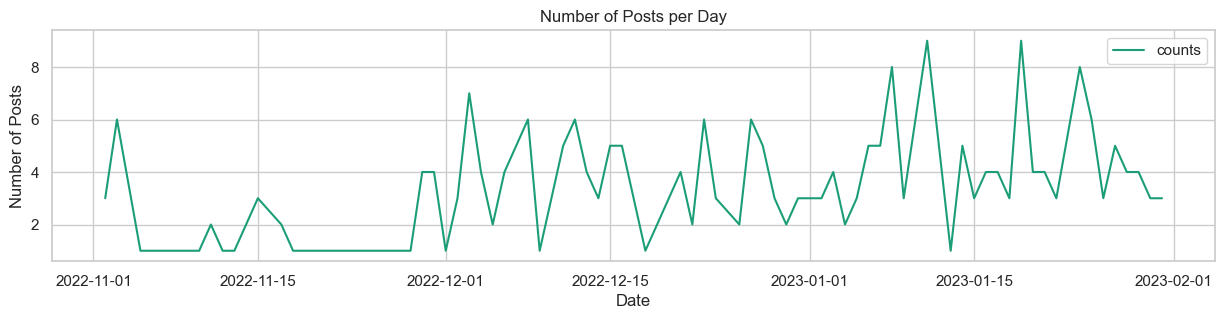

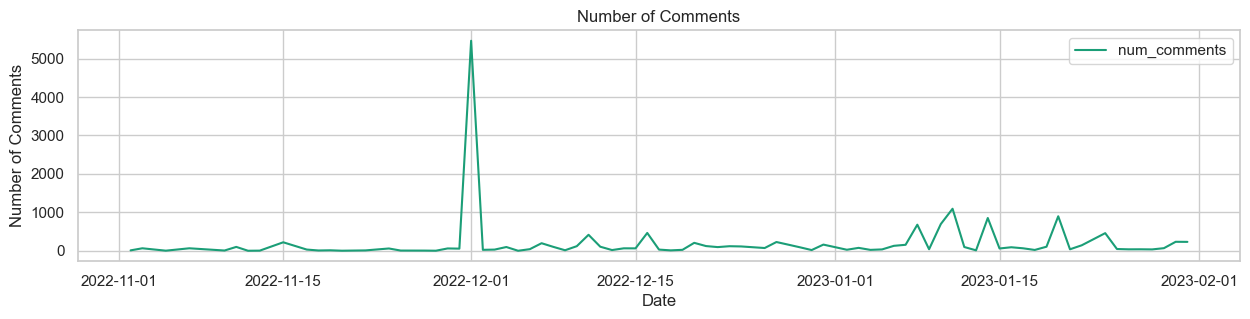

In [33]:
# Prepare data for plotting either based on the number of posts or the number of comments
df_p.plot(x='dtdate', y='counts', kind='line', title='Number of Posts per Day', xlabel='Date', ylabel='Number of Posts', figsize=(15, 3))

df_c.plot(x='dtdate', y='num_comments', kind='line', title='Number of Comments', xlabel='Date', ylabel='Number of Comments', figsize=(15, 3))

<Axes: title={'center': 'Number of Comments All Days'}, xlabel='Date', ylabel='Number of Comments'>

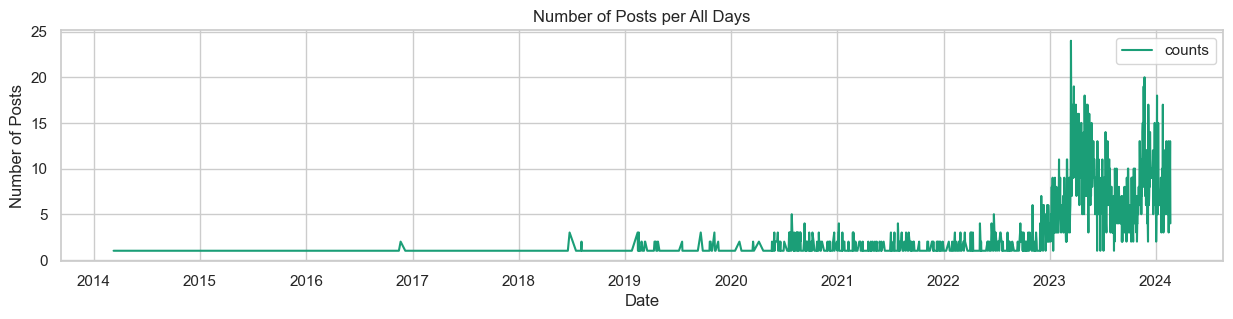

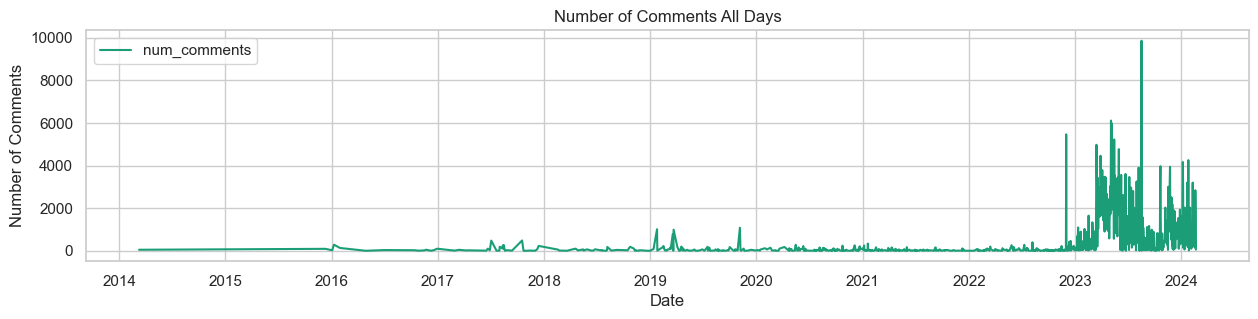

In [34]:
df_px.plot(x='dtdate', y='counts', kind='line', title='Number of Posts per All Days', xlabel='Date', ylabel='Number of Posts', figsize=(15, 3))

df_cx.plot(x='dtdate', y='num_comments', kind='line', title='Number of Comments All Days', xlabel='Date', ylabel='Number of Comments', figsize=(15, 3))

In [35]:
df_px

,dtdate,counts
855,2014-03-10,1
669,2015-12-11,1
672,2016-01-03,1
809,2016-01-09,1
819,2016-01-30,1
...,...,...
79,2024-02-16,11
96,2024-02-17,10
169,2024-02-18,8
49,2024-02-19,13


In [36]:
df_p.index = pd.to_datetime(df_p['dtdate'], format='%Y-%m-%d')

In [37]:
df_px.index = pd.to_datetime(df_px['dtdate'], format='%Y-%m-%d')

In [38]:
del df_p['dtdate']

In [39]:
del df_px['dtdate']

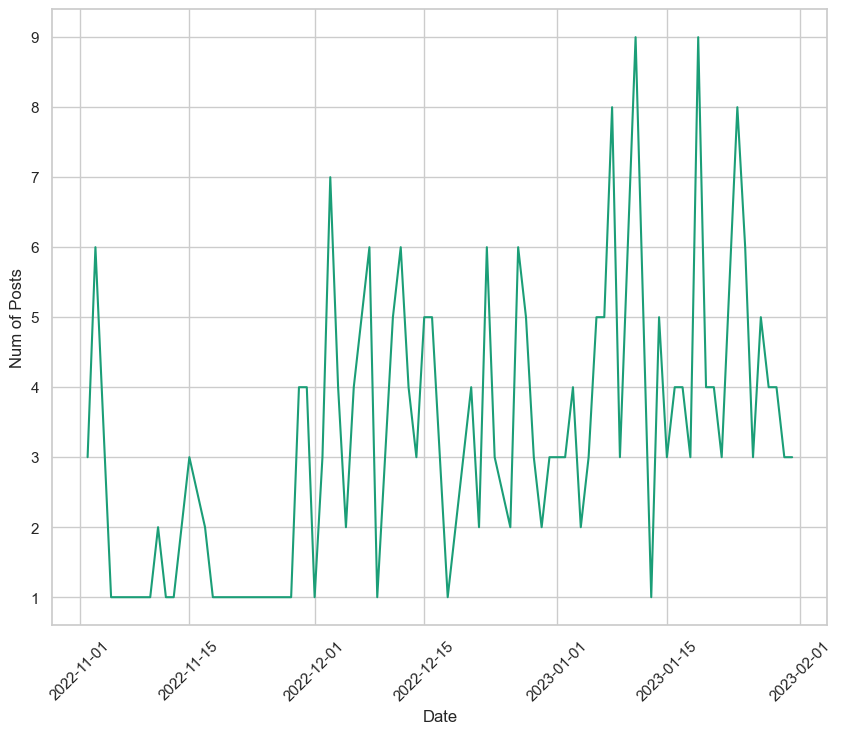

In [40]:
plt.ylabel('Num of Posts')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(df_p.index, df_p['counts'], )

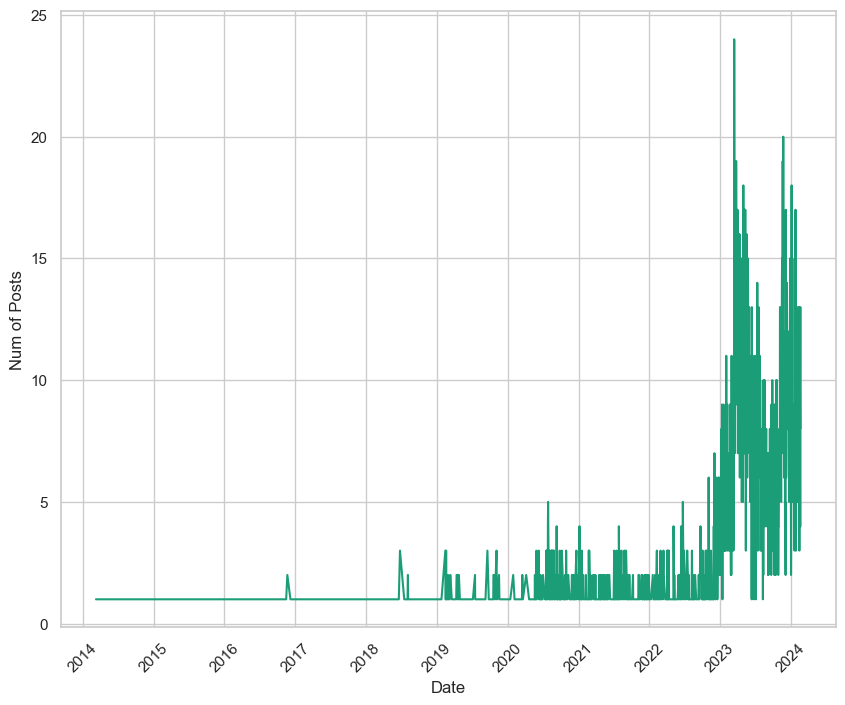

In [41]:
plt.ylabel('Num of Posts')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(df_px.index, df_px['counts'], )

In [42]:
gpt3_startdate = pd.to_datetime("2022-10-31", format='%Y-%m-%d')
gpt3_enddate = pd.to_datetime("2023-02-01", format='%Y-%m-%d')

gpt4_startdate = pd.to_datetime("2023-01-31", format='%Y-%m-%d')
gpt4_enddate = pd.to_datetime("2023-03-15", format='%Y-%m-%d')

In [43]:
trainx = df_px[(df_px.index > gpt3_startdate) & (df_px.index < gpt3_enddate)]
testx = df_px[(df_px.index > gpt4_startdate) & (df_px.index < gpt4_enddate)]

In [44]:
print("Train Periode: "+str(trainx.index.min())+" to "+str(trainx.index.max()))
print("Test Periode: "+str(testx.index.min())+" to "+str(testx.index.max()))

Train Periode: 2022-11-02 00:00:00 to 2023-01-31 00:00:00
Test Periode: 2023-02-01 00:00:00 to 2023-03-14 00:00:00


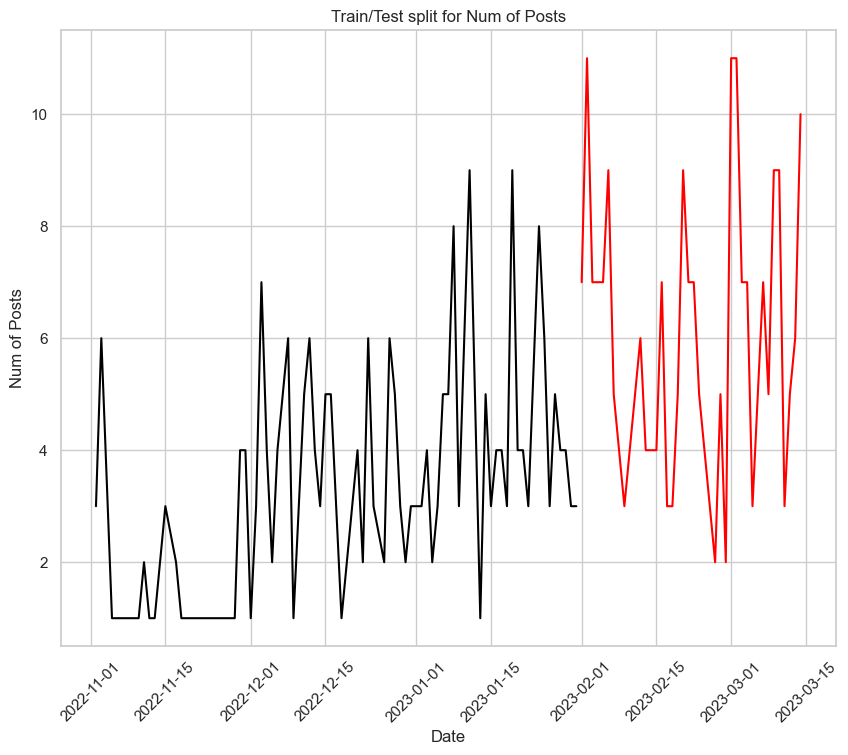

In [45]:
plt.plot(trainx, color = "black")
plt.plot(testx, color = "red")
plt.ylabel('Num of Posts')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Num of Posts")
plt.show()

In [46]:
yx = trainx['counts']

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Pred

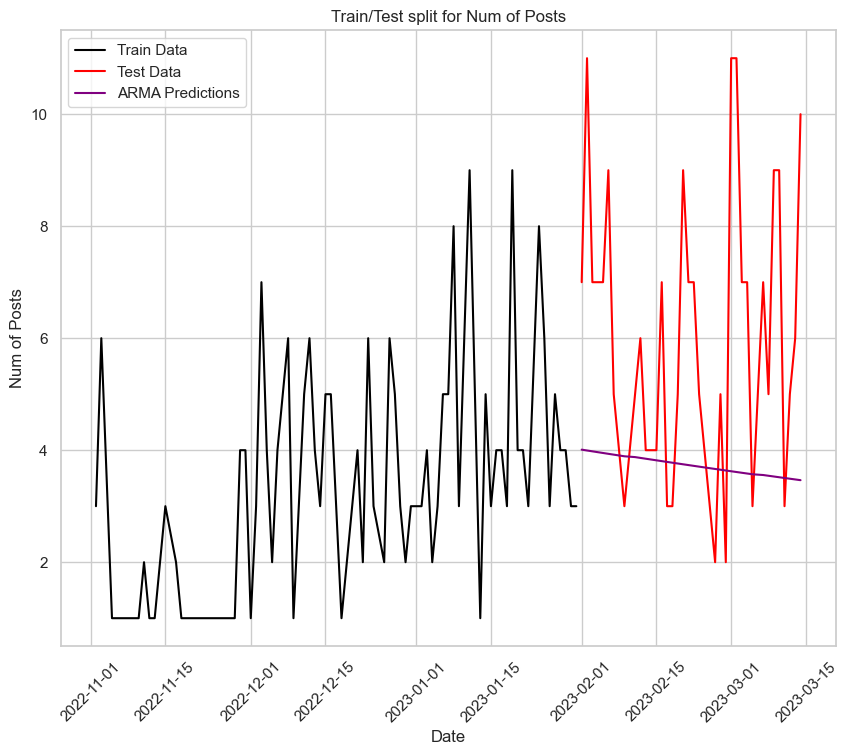

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

ARMAmodel = SARIMAX(yx, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

y_predARMA = ARMAmodel.get_forecast(len(testx.index))
y_predARMA_df = y_predARMA.conf_int(alpha = 0.05) 
y_predARMA_df["Predictions"] = ARMAmodel.predict(start = y_predARMA_df.index[0], end = y_predARMA_df.index[-1])
y_predARMA_df.index = testx.index
y_predARMA_out = y_predARMA_df["Predictions"] 

plt.plot(trainx, color = "black", label = 'Train Data')
plt.plot(testx, color = "red", label = 'Test Data')
plt.plot(y_predARMA_out, color='purple', label = 'ARMA Predictions')
plt.ylabel('Num of Posts')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Num of Posts")
plt.legend()
plt.show()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is

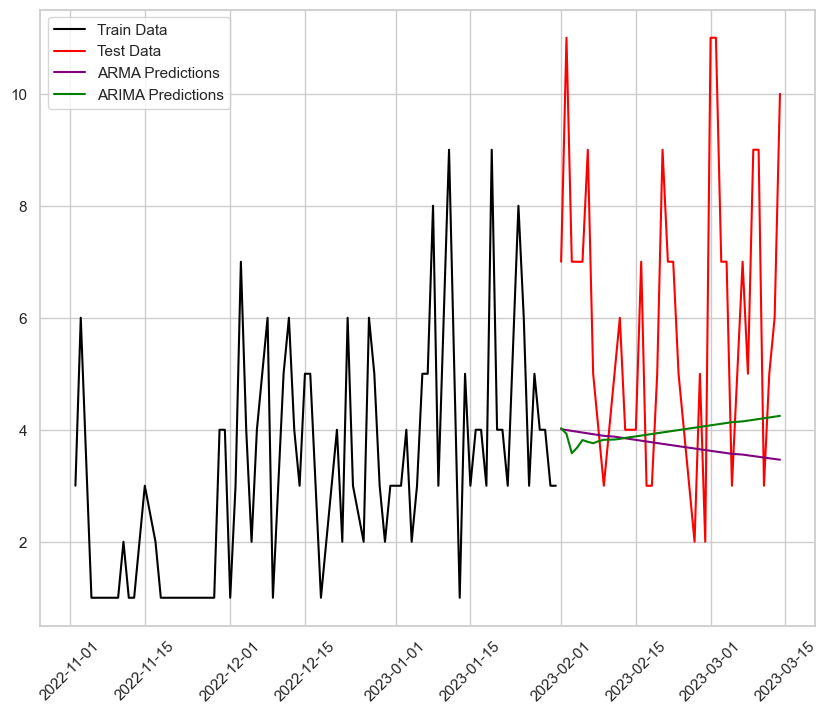

In [48]:
from statsmodels.tsa.arima.model import ARIMA

ARIMAmodel = ARIMA(yx, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_predARIMA = ARIMAmodel.get_forecast(len(testx.index))
y_predARIMA_df = y_predARIMA.conf_int(alpha = 0.05) 
y_predARIMA_df["Predictions"] = ARIMAmodel.predict(start = y_predARIMA_df.index[0], end = y_predARIMA_df.index[-1])
y_predARIMA_df.index = testx.index
y_predARIMA_out = y_predARIMA_df["Predictions"] 

plt.plot(trainx, color = "black", label = 'Train Data')
plt.plot(testx, color = "red", label = 'Test Data')
plt.plot(y_predARMA_out, color='purple', label = 'ARMA Predictions')
plt.plot(y_predARIMA_out, color='green', label = 'ARIMA Predictions')
plt.xticks(rotation=45)
plt.legend()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction resul

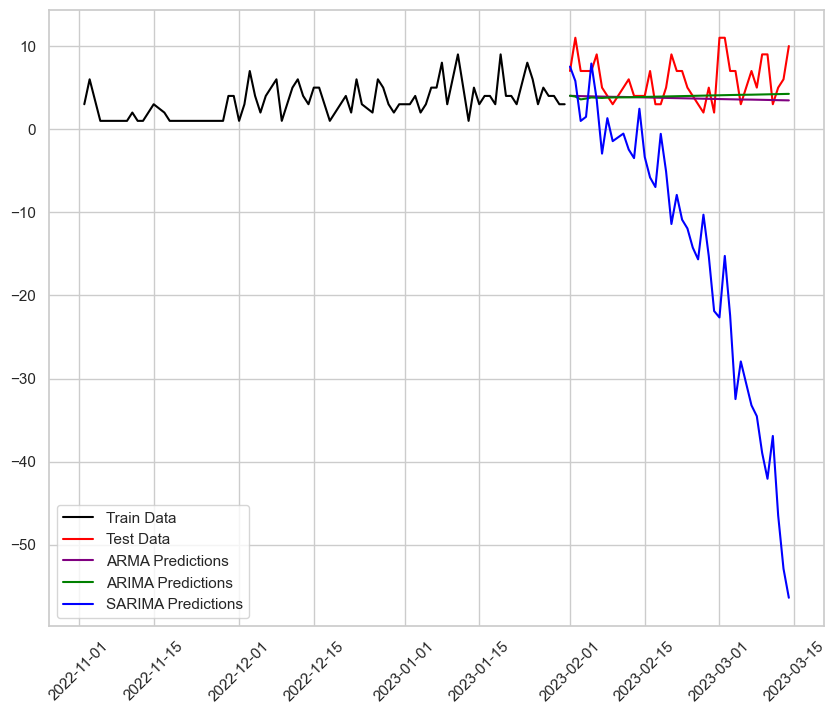

In [49]:
SARIMAXmodel = SARIMAX(yx, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_predSARIMAX = SARIMAXmodel.get_forecast(len(testx.index))
y_predSARIMAX_df = y_predSARIMAX.conf_int(alpha = 0.05) 
y_predSARIMAX_df["Predictions"] = SARIMAXmodel.predict(start = y_predSARIMAX_df.index[0], end = y_predSARIMAX_df.index[-1])
y_predSARIMAX_df.index = testx.index
y_predSARIMAX_out = y_predSARIMAX_df["Predictions"]

plt.plot(trainx, color = "black", label = 'Train Data')
plt.plot(testx, color = "red", label = 'Test Data')
plt.plot(y_predARMA_out, color='purple', label = 'ARMA Predictions')
plt.plot(y_predARIMA_out, color='green', label = 'ARIMA Predictions')
plt.plot(y_predSARIMAX_out, color='Blue', label = 'SARIMA Predictions')
plt.xticks(rotation=45)
plt.legend()

In [50]:
from sklearn.metrics import mean_squared_error

In [51]:
arma_rmse = np.sqrt(mean_squared_error(testx["counts"].values, y_predARMA_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  3.3496604678701245


In [52]:
arima_rmse = np.sqrt(mean_squared_error(testx["counts"].values, y_predARIMA_df["Predictions"]))
print("RMSE: ",arima_rmse)

RMSE:  3.170038966994335


In [53]:
sarimax_rmse = np.sqrt(mean_squared_error(testx["counts"].values, y_predSARIMAX_df["Predictions"]))

print("RMSE: ",sarimax_rmse)

RMSE:  27.05248869975743
